# WARNING!!!

After pulling down the tutorial notebook, immediately make a copy. Then do not modify the original. Do your work in the copy. This will prevent the possibility of git conflicts should the version-controlled file change at any point in the future.

This notebook is developed as part of the [KIPAC/StatisticalMethods course](https://github.com/KIPAC/StatisticalMethods), (c) 2019 Adam Mantz, licensed under the GPLv2.

If the following cell is confusing, read the `KIPAC/StatisticalMethods` tutorial [how-to](howto.ipynb).

In [ ]:
class SolutionMissingError(Exception):
    def __init__(self):
        Exception.__init__(self,"You need to complete the solution for this code to work!")
def REPLACE_WITH_YOUR_SOLUTION():
    raise SolutionMissingError
REMOVE_THIS_LINE = REPLACE_WITH_YOUR_SOLUTION

# Tutorial: Coping with Missing Information
## O-ring failure rates prior to the Challenger shuttle loss

In this tutorial, we will use a real data set where unwise data selection had serious consequences to illustrate how such selection effects could be modeled.

## Background

On January 28, 1986, the Space Shuttle Challenger was destroyed in an explosion during launch. The cause was eventually found to be the failure of an O-ring seal that normally prevents hot gas from leaking between two segments of the solid rocket motors during their burn. The ambient atmospheric temperature of just 36 degrees Fahrenheit,  significantly colder than any previous launch, was determined to be a significant factor in the failure.

A relevant excerpt from the [Report of the Presidential Commission on the Space Shuttle Challenger Accident](https://history.nasa.gov/rogersrep/genindex.htm) reads:

> #### Temperature Effects

> The record of the fateful series of NASA and Thiokol meetings, telephone conferences, notes, and facsimile transmissions on January 27th, the night before the launch of flight 51L, shows that only limited consideration was given to the past history of O-ring damage in terms of temperature. The managers compared as a function of temperature the flights for which thermal distress of O-rings had been observed-not the frequency of occurrence based on all flights (Figure 6). In such a comparison, there is nothing irregular in the distribution of O-ring "distress" over the spectrum of joint temperatures at launch between 53 degrees Fahrenheit and 75 degrees Fahrenheit. When the entire history of flight experience is considered, including"normal" flights with no erosion or blow-by, the comparison is substantially different (Figure 7).

> This comparison of flight history indicates that only three incidents of O-ring thermal distress occurred out of twenty flights with O-ring temperatures at 66 degrees Fahrenheit or above, whereas, all four flights with O-ring temperatures at 63 degrees Fahrenheit or below experienced O-ring thermal distress.

> Consideration of the entire launch temperature history indicates that the probability of O-ring distress is increased to almost a certainty if the temperature of the joint is less than 65.

<table>
    <tr>
        <td><img src="graphics/v1p146.jpg" width=110%></td>
    </tr>
</table>

The data above show the number of incidences of O-ring damage found in previous missions as a function of the temperature at launch; these have been transcribed to `data/oring.dat`:

```
temperature incidents
53 3
56 1
57 1
63 1
66 0
...
```

## Setup

Let's import some things.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings;
warnings.filterwarnings('ignore')
import pandas as pd
%pylab inline
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 15,11
sns.set_context('poster',font_scale=1.4)
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Read in the data.

In [3]:
oring_data = np.loadtxt('data/oring.dat', skiprows=1)
oring_temps = oring_data[:,0]
oring_incidents = oring_data[:,1]

Prove that we did that right (cf above).

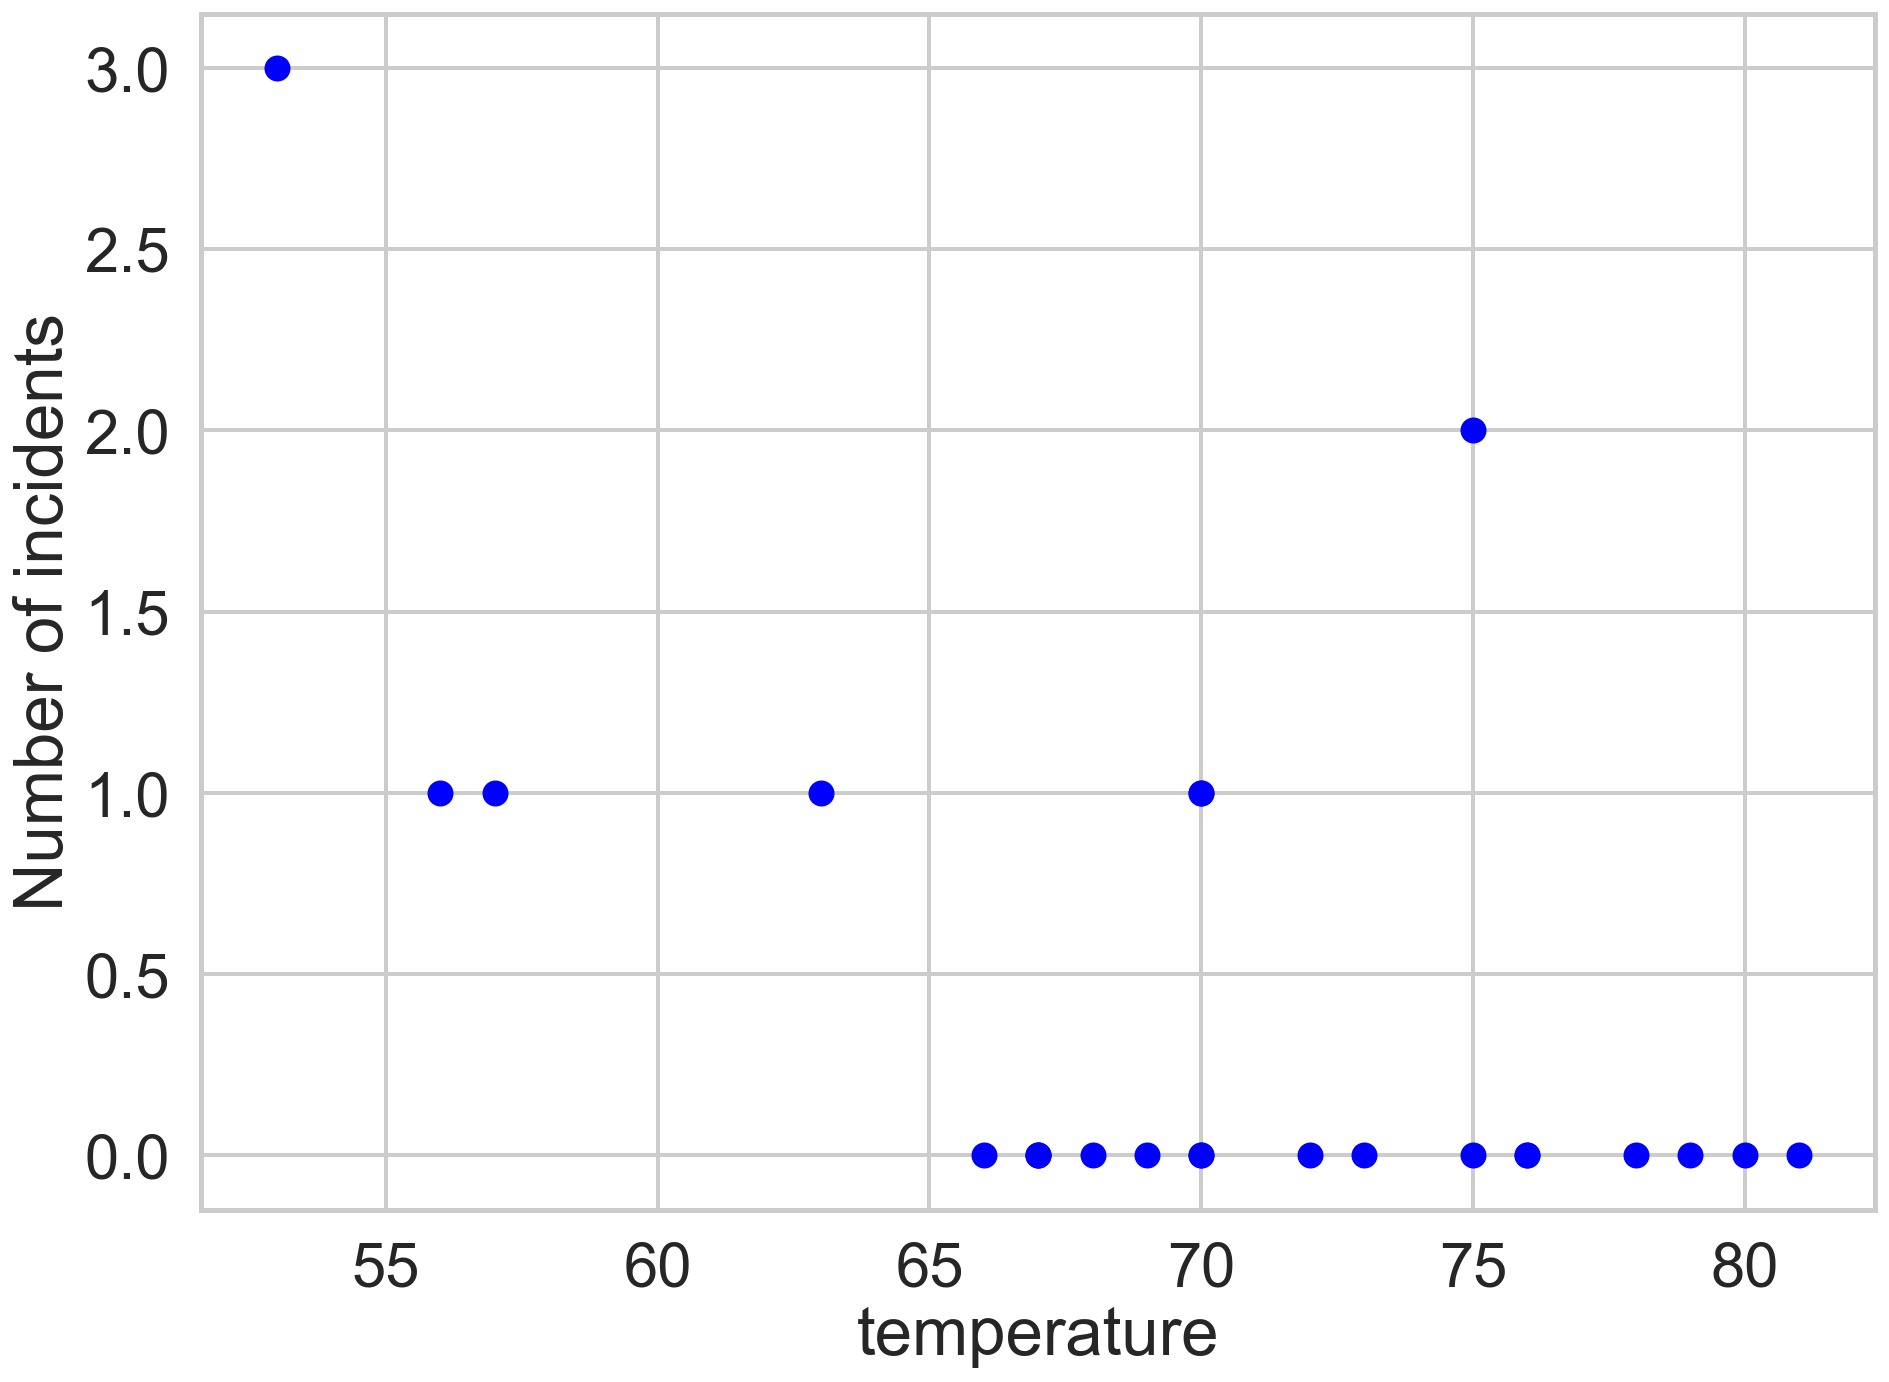

In [4]:
plt.plot(oring_temps, oring_incidents, 'bo');
plt.xlabel('temperature');
plt.ylabel('Number of incidents');

For this notebook, we will simplify the data for each launch from integer (how many incidents of O-ring damage) to boolean (was there any damage, or not).

In [5]:
failure_temps = oring_temps[np.where(oring_incidents > 0)[0]]
Nfailure = len(failure_temps)
success_temps = oring_temps[np.where(oring_incidents == 0)[0]]
Nsuccess = len(success_temps)
print('temperatures corresponding to failures:', failure_temps)
print('temperatures corresponding to successes:', success_temps)

temperatures corresponding to failures: [53. 56. 57. 63. 70. 70. 75.]
temperatures corresponding to successes: [66. 67. 67. 67. 68. 69. 70. 70. 72. 73. 75. 76. 76. 78. 79. 80. 81.]


## 1. Defining a model

Before worrying about missing data, let's define a model that we might want to fit to these data. We're interested in whether the probability of having zero O-ring incidents (or non-zero incidents, conversely) is a function of temperature. One possible parametrization that allows this is the [logistic function](https://en.wikipedia.org/wiki/Logistic_function), which squeezes the real line onto the range (0,1).

For reasons that may be clear later, I suggest defining the model in terms of the probability of success (zero incidents)

$P_\mathrm{success}(T|T_0,T_s) = \frac{1}{1 + e^{-(T-T_0)/T_s}}$,

with parameters $T_0$ and $T_s$ respectively determining the center and width of the logistic function.

> Ed. note: This turns out to be a spectacularly stupid choice of model, for reasons that hopefully will be clear once you visualize the fits below. If you'd like to propose something different, feel free; otherwise hold your nose and carry on.

### 1a. Implement this function and have a look

In [16]:
def P_success(T, T0, Ts):
    return 1/(1+np.exp((-T+T0)/Ts))

Plot the function for a few different parameter values.

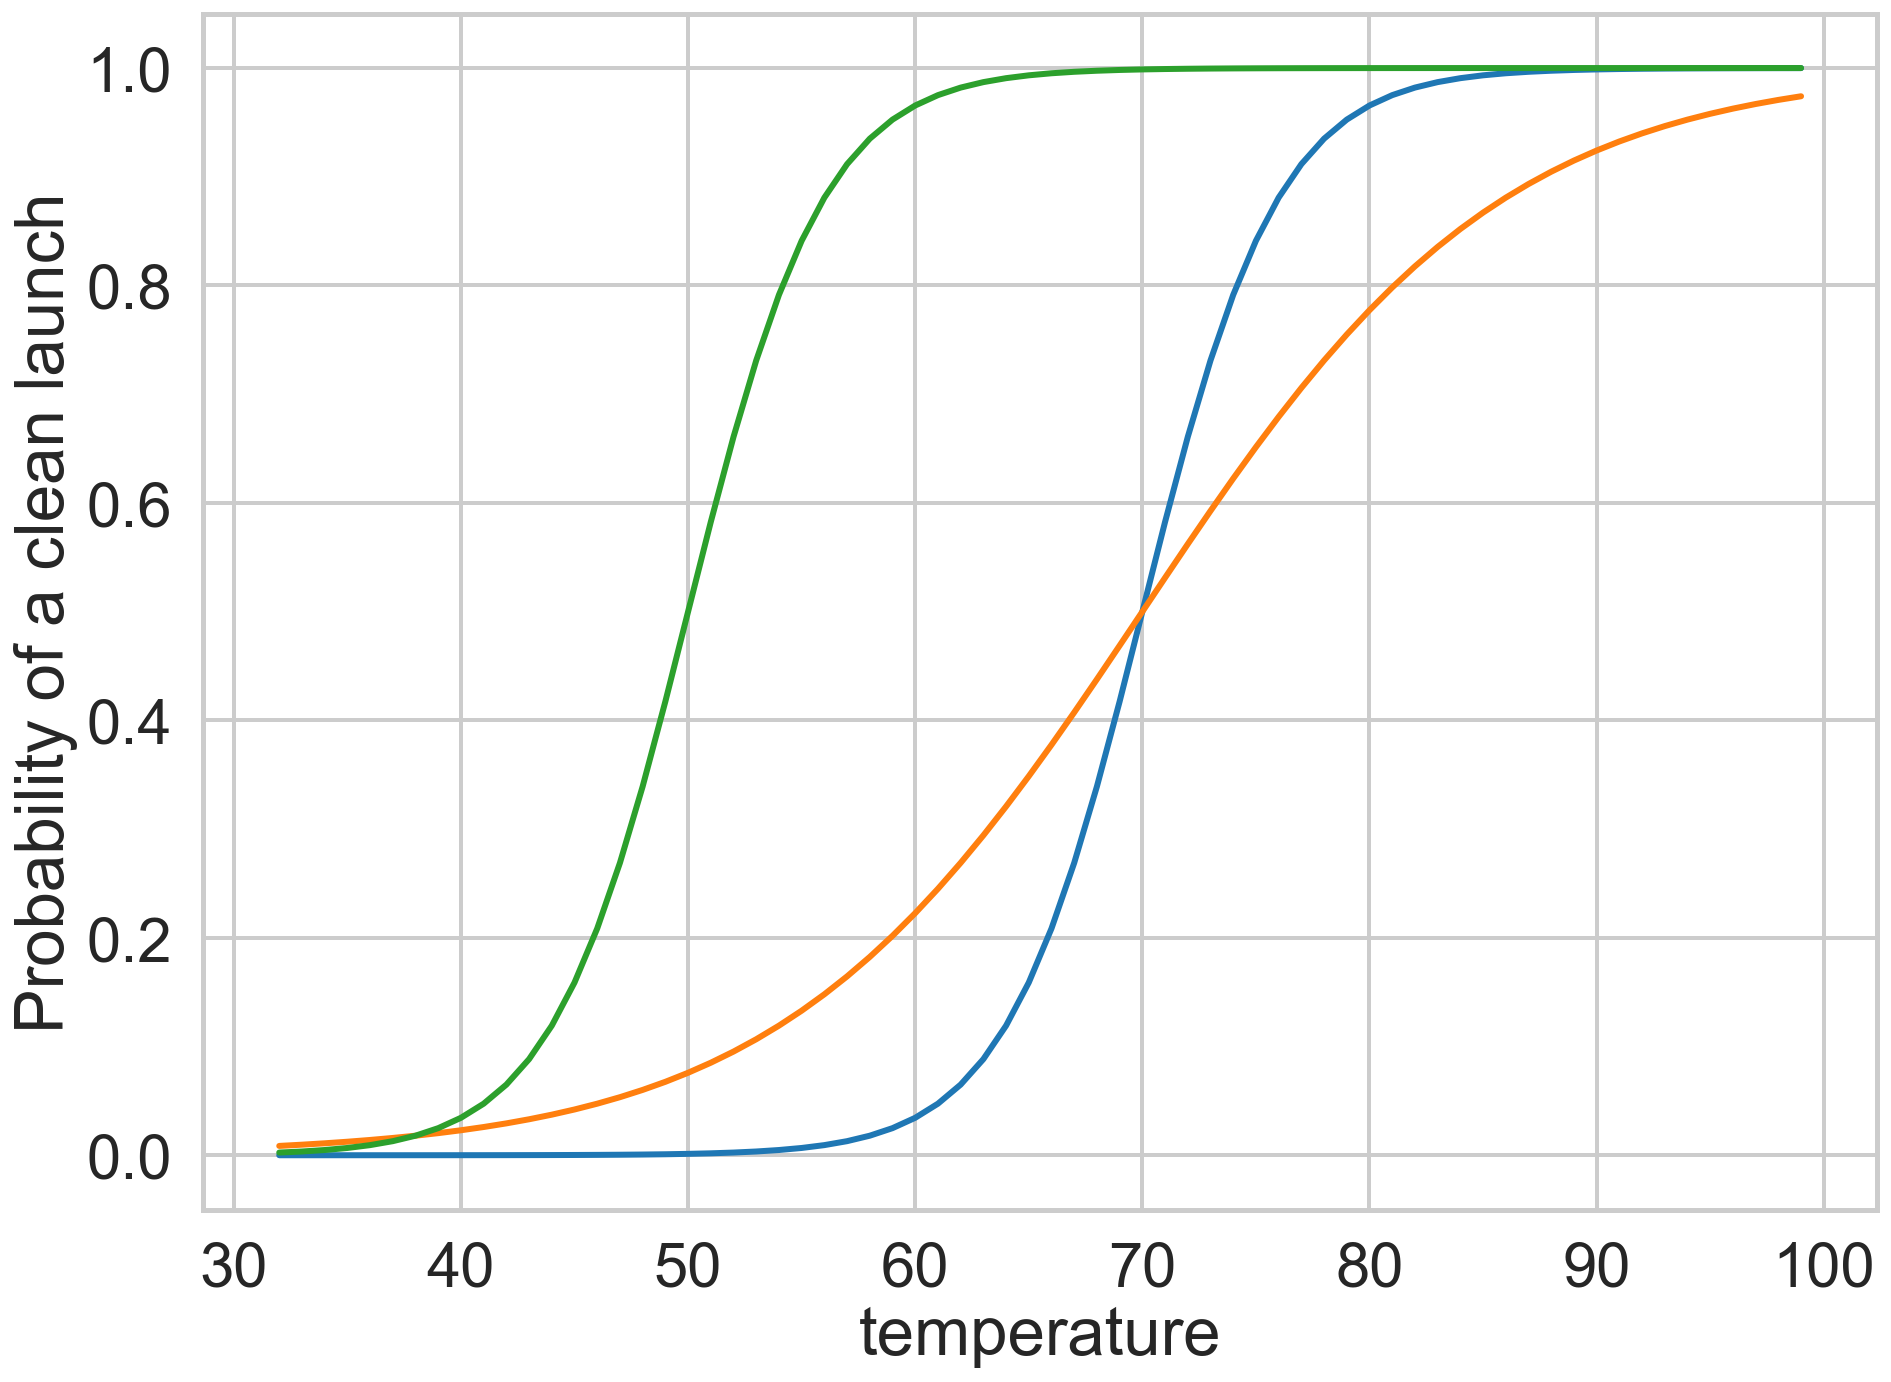

In [17]:
T_axis = np.arange(32., 100.)
plt.plot(T_axis, P_success(T_axis, 70., 3.));
plt.plot(T_axis, P_success(T_axis, 70., 8.));
plt.plot(T_axis, P_success(T_axis, 50., 3.));
plt.xlabel('temperature');
plt.ylabel('Probability of a clean launch');
#plt.ylim((0,1))

### 1b. PGM and priors

Given the definition of the data and model above, draw the PGM for this problem, and write down an expression for the likelihood.

Choose priors for any parameters that need them. (As always, these should *not* be chosen based on looking at the data.) Complete the function below implementing the (log-)priors you've chosen.

In [21]:
def ln_prior(T0, Ts):
    return 1/(T0) + 1/Ts

## 2. Censored success temperatures

Imagine we are in a slightly better situation than that shown in Figure 6 from the report. Namely, we are given
1. the temperatures of launches where there were O-ring failures (`failure_temps` and `Nfailure` above),
2. the number of launches with no failures (`Nsuccess`),
3. a range of temperatures containing the successful launches, but **not** the precise temperatures of each.

For (3), you can use the actual min and max of `success_temps` if you want to, or base your analysis on something more vague like the range [50,100]. Either way, define those variables here:

In [23]:
success_Tmin = 50
success_Tmax = 100

### 2a. Censored model definition

Work out how to adjust your PGM and expression for the likelihood to reflect our ignorance of the temperatures of successful launches.

Implement the (log)-likelihood for the censored model. Uncomment the cells below to see some hints if you want.

In [18]:
print(open('hints/hint1.txt').read())

Hint: this doesn't require as dramatic a change to the model as truncation would, more a re-definition of the sampling distribution for the censored points.



In [19]:
print(open('hints/hint2.txt').read())

Hint: a model component that was previously fixed by observation or effectively determined precisely is now indeterminate.



In [20]:
print(open('hints/hint3.txt').read())

Hint: we can marginalize over our newfound ignorance analytically, taking advantage of the fact that the integral of the logistic function is analytic (https://en.wikipedia.org/wiki/Logistic_function).



In [ ]:
def ln_like(REPLACE_WITH_YOUR_ARGUMENT_LIST_OF_CHOICE):
    REPLACE_WITH_YOUR_SOLUTION()

### 2b. Censored model fit

Let's look at the posterior from your censored model. In addition to the parameter constraints themselves, we might be interested in the marginalized posteriors for
1. the failure probability evaluated at 36 degrees for this data selection and under this model. (Recall that the report states, presumably by inspection, that "the probability of O-ring distress is increased to almost a certainty if the temperature of the joint is less than 65".)
2. the difference in failure probability between ,e.g., 36 and 72 degrees, as a proxy for whether a temperature dependent effect exists.

Since the point of this tutorial is model design rather than carrying out a fit, most of the code below is given. It implements a simple, brute-force evaluation of the posterior on a grid, since this is only a 2-parameter model. Naturally, you should ensure that you understand what the code is doing, even if there's nothing to add.

Define grid points in $T_0$ and $T_s$.

In [ ]:
post_T0 = np.arange(50., 80.5, 0.5)
post_Ts = np.arange(0.25, 20.1, 0.25)

Evaluate the log-posterior on a grid, and renormalize it to ensure that things remain numerically safe when we exponentiate. Then do so.

In [ ]:
# Fill in the call to your log-likelihood function
try:
    exec(open('solutions/getpost.py').read())
except IOError:
    post_lnp = np.array( [ [ln_prior(T0,Ts)+REPLACE_WITH_YOUR_SOLUTION() for T0 in post_T0] for Ts in post_Ts] )

post_lnp -= np.max(post_lnp)
post_p = np.exp(post_lnp)

Make some plots summarizing the 2D and 1D posteriors of the parameters. The 2D plot shows *approximate* 68.3% and 95.4% credible regions based on the central limit theorem (i.e. assuming they are defined by threshold values of $-2\Delta\log p$). This should be fine for qualitatively evaluating the constraints, but feel free to do a better job if you want.

In [ ]:
# 2D parameter constraints
plt.contour(post_T0, post_Ts, post_lnp, -0.5*np.array([6.18, 2.3]), colors='blue', linestyles='solid');
plt.xlabel(r'$T_0$');
plt.ylabel(r'$T_s$');
plt.title(r'$p(T_0,T_s|\mathrm{data})$');

In [ ]:
# 1D posterior
plt.plot(post_T0, np.sum(post_p, axis=0));
plt.xlabel(r'$T_0$');
plt.ylabel(r'$p(T_0|\mathrm{data})$');

In [ ]:
# 1D posterior
plt.plot(post_Ts, np.sum(post_p, axis=1));
plt.xlabel(r'$T_s$');
plt.ylabel(r'$p(T_s|\mathrm{data})$');

To evaluate the posterior prediction for the failure probability at a given temperature, we need to marginalize over the model parameters. That is, we need the posterior-weighted average of $1-P_\mathrm{success}$ over the parameter space. This function takes the posterior array as an argument so that we can re-use it in the next section.

In [ ]:
def posterior_prediction_Pfailure(T, post):
    return np.average([ [1.0-P_success(T,T0,Ts) for T0 in post_T0] for Ts in post_Ts], weights=post)

In [ ]:
post_fail_temp = np.arange(30., 85.)
post_fail_prob = [ posterior_prediction_Pfailure(T, post_p) for T in post_fail_temp ]

In [ ]:
plt.plot(post_fail_temp, post_fail_prob);
plt.xlabel(r'$T$');
plt.ylabel(r'$P_\mathrm{failure}(T)$');

Something to think about: how would you go about quantifying the significance of a temperature dependent effect, given this model?

## 3. Complete data

For comparison, let's see how the constraints differ if we use the complete (uncensored) data set.

Implement the likelihood for the original, uncensored model.

In [ ]:
try:
    exec(open('solutions/likelihoodcomplete.py').read())
except IOError:
    REMOVE_THIS_LINE()
    def ln_like_complete(REPLACE_WITH_YOUR_ARGUMENT_LIST_OF_CHOICE):
        REPLACE_WITH_YOUR_SOLUTION()

Now we go through the same evaluations of the posterior as above, and compare the two sets results.

In [ ]:
# Again, just fill in the call to your version of ln_like_complete
try:
    exec(open('solutions/getpostcomplete.py').read())
except IOError:
    post_lnp_complete = np.array( [ [ln_prior(T0,Ts)+REPLACE_WITH_YOUR_SOLUTION() for T0 in post_T0] for Ts in post_Ts] )

post_lnp_complete -= np.max(post_lnp_complete)
post_p_complete = np.exp(post_lnp_complete)

In [ ]:
post_fail_prob_complete = [ posterior_prediction_Pfailure(T, post_p_complete) for T in post_fail_temp ]

In [ ]:
# 2D parameter constraints
plt.contour(post_T0, post_Ts, post_lnp, -0.5*np.array([6.18, 2.3]), colors='blue', linestyles='solid');
plt.contour(post_T0, post_Ts, post_lnp_complete, -0.5*np.array([6.18, 2.3]), colors='red', linestyles='dashed');
plt.xlabel(r'$T_0$');
plt.ylabel(r'$T_s$');
plt.title(r'$p(T_0,T_s|\mathrm{data})$');

In [ ]:
# 1D posterior
plt.plot(post_T0, np.sum(post_p, axis=0), 'b-');
plt.plot(post_T0, np.sum(post_p_complete, axis=0), 'r--');
plt.xlabel(r'$T_0$');
plt.ylabel(r'$p(T_0|\mathrm{data})$');

In [ ]:
# 1D posterior
plt.plot(post_Ts, np.sum(post_p, axis=1), 'b-');
plt.plot(post_Ts, np.sum(post_p_complete, axis=1), 'r--');
plt.xlabel(r'$T_s$');
plt.ylabel(r'$p(T_s|\mathrm{data})$');

In [ ]:
plt.plot(post_fail_temp, post_fail_prob, 'b-');
plt.plot(post_fail_temp, post_fail_prob_complete, 'r--');
plt.xlabel(r'$T$');
plt.ylabel(r'$P_\mathrm{failure}(T)$');

Does the comparison make sense? If not, what do you think might be going on?

## Challenge Problems

### 4. Truncation

Modify the model such that the launches with zero O-ring incidents are truncated rather than censored. We no longer know how many such data points there are in the complete data set. If you want, you can still use prior information on the temperature range that incident-free lauches happened in (as above), and some vague prior on the total number of launches (25ish). Run through the analysis in this scenario and compare the results with those above.

### 5. Truncated linear regression as the limit of a binned a Poisson process

Work through the derivation sketched below the header **"Don't believe me?"** in the missing data lecture notes.

### 6. Playtime

Continue playing with the O-ring problem. Perhaps you could propose a less ridiculous model for the success probability, devise a goodness of fit metric or explore the impact of different missing data patterns.